# Read in the data

In [1]:
import pandas as pd
import numpy
import re
import matplotlib.pyplot as plt

%matplotlib inline

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [2]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns

In [3]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [4]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [5]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [6]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [7]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [8]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [9]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

# Plotting survey correlations

In [10]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

In [11]:
x_val = numpy.arange(0, len(survey_fields))
height = correlations[survey_fields]

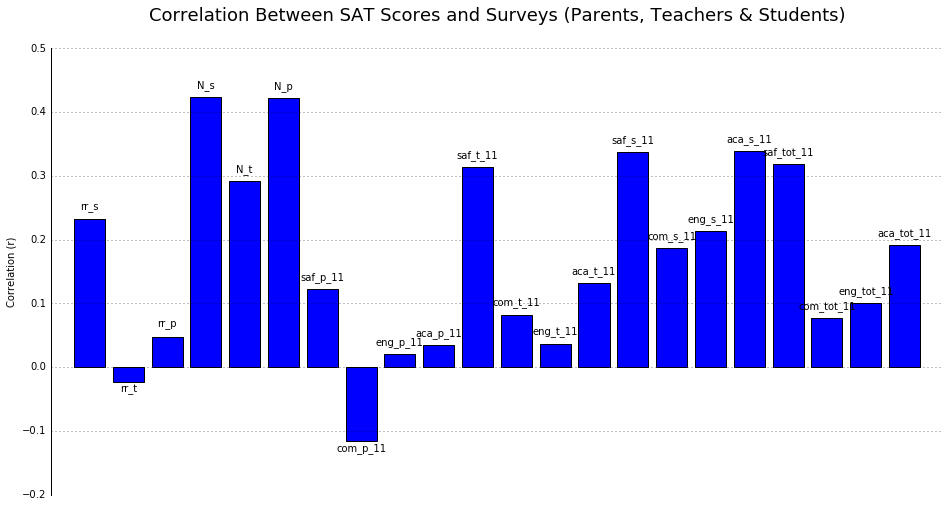

In [40]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16,8))

ax.bar(x_val, height, align='center');

ax.set_xbound(-1, 22)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)

ax.tick_params(
    axis='both',       
    which='both',      
    bottom=False,      
    top=False,         
    right=False,
    left=False,
    labelbottom=False) 

ax.grid(axis='y')

rects = ax.patches

for rect, label, corr in zip(rects, survey_fields, height):
    h = rect.get_height()
    if corr < 0:
        h = -1*h - 0.03 
    ax.text(rect.get_x() + rect.get_width() / 2, h + 0.01, label,
            ha='center', va='bottom')

plt.title('Correlation Between SAT Scores and Surveys (Parents, Teachers & Students)',
             fontsize=18, y=1.05)
ax.set_ylabel('Correlation (r)')

plt.show()

## Correlations Between SAT Scores and Surveys
From the graph above, there appears to be a moderately strong correlation between the number of student respondents and SAT scores (N_s) as well as between the number of parent respondents and SAT scores (N_t), r~0.42. There also appears to be a slight correlation between the Safety and Respect Score as reported by students (saf_s_11) and SAT scores. This also goes for the Academic Expectation Score as reported by students (aca_s_11) and Safety and Respect Score as reported by teachers (saf_t_11).

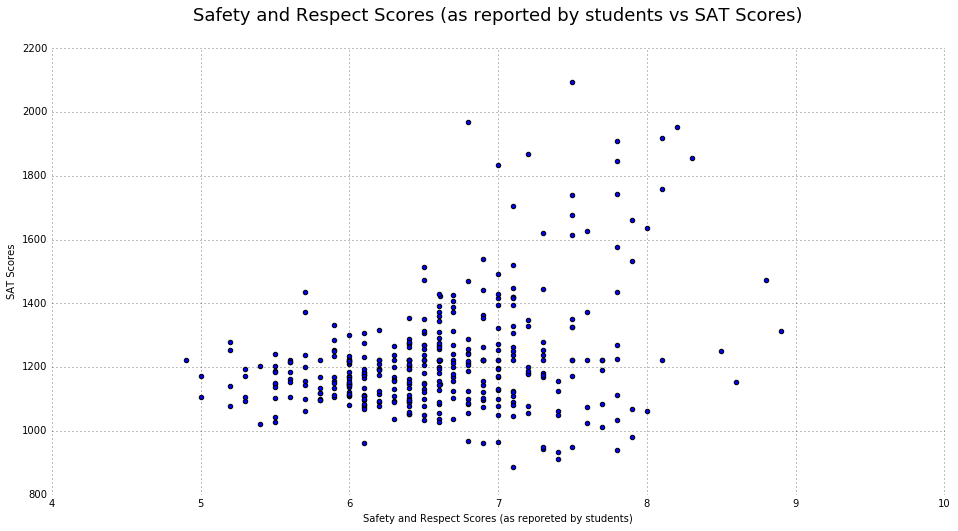

In [15]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16,8))

ax.scatter(x=combined['saf_s_11'], y=combined['sat_score'])

ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)

ax.grid(axis='both')

ax.tick_params(
    axis='both',        
    which='both',      
    bottom=False,      
    top=False,         
    right=False,
    left=False)

plt.title('Safety and Respect Scores (as reported by students vs SAT Scores)',
             fontsize=18, y=1.05)

ax.set_xlabel('Safety and Respect Scores (as reporeted by students)')
ax.set_ylabel('SAT Scores')

plt.show()

## Correlation between Safety and Respect Score (as reported by students) vs SAT Scores

There appears to be a slight upward trend between the relationship of the Safety and Respect Score (as reported by students) vs SAT Scores for the high schools in New York City. I wouldn't say that this relationship is a particularly strong one and the clustering at around 6.5 in SAR and 1200 SAT Score could account for the relatively high r score.

In [22]:
districts = combined.groupby('school_dist').apply(numpy.mean)

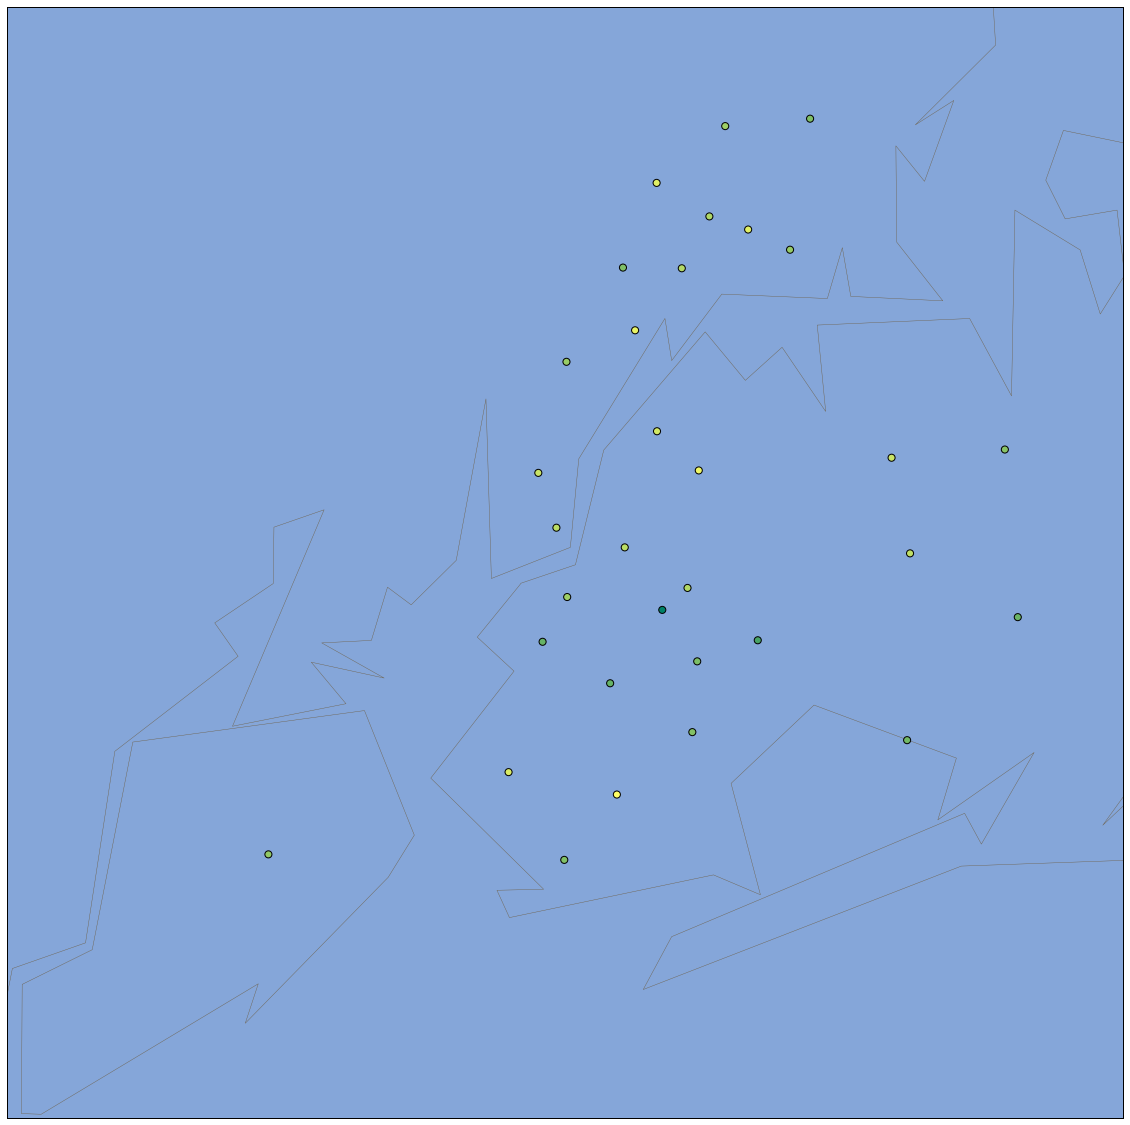

In [36]:
from mpl_toolkits.basemap import Basemap

fig = plt.figure(figsize=(20,20))

m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i'
)

m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)

longitudes = districts['lon'].tolist()
latitudes = districts['lat'].tolist()

m.scatter(x=longitudes, y=latitudes, s=50, zorder=2, latlon=True,
          c=districts['saf_tot_11'], cmap='summer')

plt.show()

## Safety and Respect of Each Borough 
It appears that the schools in the districts that correpsond to lower Manhattan, East Queens and the center of Brooklyn have the lowest Safety and Respect Scores. This seems to correspond to the relatively high crimes associated with those areas, see [link](https://streeteasy.com/blog/safest-areas-nyc/).

In [41]:
race_cols = ['white_per', 'asian_per', 'black_per', 'hispanic_per']

x_val = numpy.arange(0, len(race_cols))
height = correlations[race_cols]

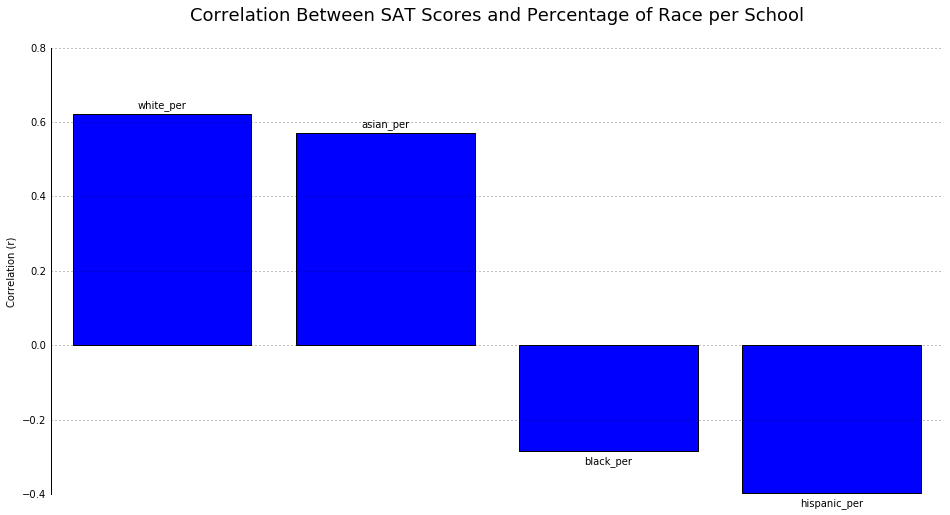

In [45]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16,8))

ax.bar(x_val, height, align='center');

# ax.set_xbound(-1, 22)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)

ax.tick_params(
    axis='both',       
    which='both',      
    bottom=False,      
    top=False,         
    right=False,
    left=False,
    labelbottom=False) 

ax.grid(axis='y')

rects = ax.patches

for rect, label, corr in zip(rects, race_cols, height):
    h = rect.get_height()
    if corr < 0:
        h = -1*h - 0.05 
    ax.text(rect.get_x() + rect.get_width() / 2, h + 0.01, label,
            ha='center', va='bottom')

plt.title('Correlation Between SAT Scores and Percentage of Race per School',
             fontsize=18, y=1.05)
ax.set_ylabel('Correlation (r)')

plt.show()

## Correlation Between SAT Scores and Percentage of Race per School
There appears to be a relatively strong correlation between the percentage of white or asian students and how well on average that school performs on the SAT. Unfortunately, the reverse is true for schools with high percentages of black or hispanic students. 

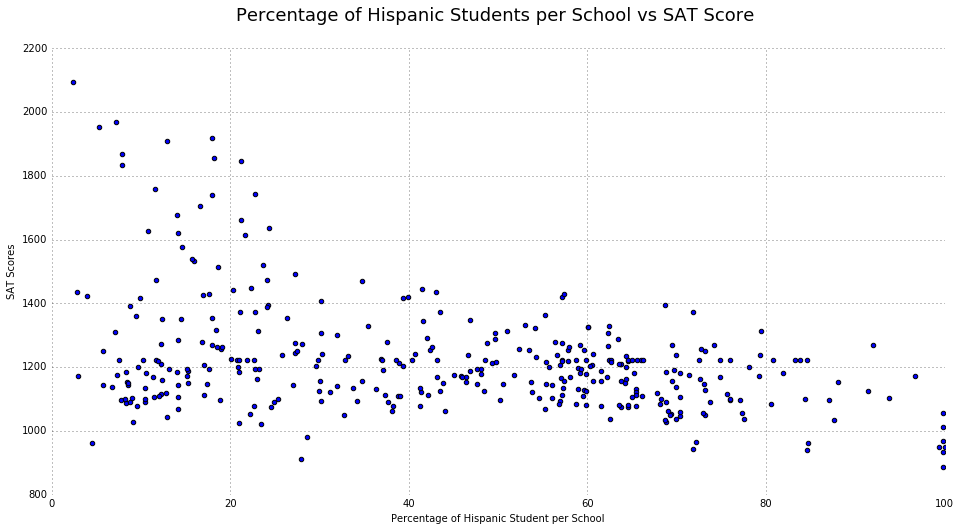

In [48]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16,8))

ax.scatter(x=combined['hispanic_per'], y=combined['sat_score'])

ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)

ax.grid(axis='both')

ax.set_xbound(0,100)

ax.tick_params(
    axis='both',        
    which='both',      
    bottom=False,      
    top=False,         
    right=False,
    left=False)

plt.title('Percentage of Hispanic Students per School vs SAT Score ',
             fontsize=18, y=1.05)

ax.set_xlabel('Percentage of Hispanic Student per School')
ax.set_ylabel('SAT Scores')

plt.show()

## Correlation Between Percentage of Hispanic Students per School and SAT Score
Unfortunately, there appears to be a negative relationship between the percentage of hispanic students at a given school and the school's average SAT Score. The correlation is extremely strong and there may be other factors involved but this should be investigated further. 

In [50]:
combined[combined['hispanic_per'] > 95]


,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,...,priority05,priority06,priority07,priority08,priority09,priority10,Location 1,lat,lon,school_dist
44,02M542,MANHATTAN BRIDGES HIGH SCHOOL,66,336.0,378.0,344.0,1058.0,Manhattan Bridges High School,67.000000,102.000000,...,0,0,0,0,0,0,"525 West 50Th Street\nNew York, NY 10019\n(40....",40.765027,-73.992517,02
82,06M348,WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL,70,380.0,395.0,399.0,1174.0,0,129.028846,197.038462,...,Then to New York City residents,0,0,0,0,0,"511 West 182Nd Street\nNew York, NY 10033\n(40...",40.848879,-73.930807,06
89,06M552,GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...,56,339.0,349.0,326.0,1014.0,GREGORIO LUPERON HS SCI & MATH,88.000000,138.000000,...,0,0,0,0,0,0,"501 West 165Th\nNew York, NY 10032\n(40.838032...",40.838032,-73.938371,06
125,09X365,ACADEMY FOR LANGUAGE AND TECHNOLOGY,54,315.0,339.0,297.0,951.0,Academy for Language and Technology,20.000000,20.000000,...,0,0,0,0,0,0,"1700 Macombs Road\nBronx, NY 10453\n(40.849102...",40.849102,-73.916088,09
141,10X342,INTERNATIONAL SCHOOL FOR LIBERAL ARTS,49,300.0,333.0,301.0,934.0,International School for Liberal Arts,55.000000,73.000000,...,0,0,0,0,0,0,"2780 Reservoir Avenue\nBronx, NY 10468\n(40.87...",40.870377,-73.898163,10
176,12X388,PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE,30,321.0,351.0,298.0,970.0,0,129.028846,197.038462,...,0,0,0,0,0,0,"1300 Boynton Avenue\nBronx, NY 10472\n(40.8313...",40.831366,-73.878823,12
253,19K583,MULTICULTURAL HIGH SCHOOL,29,279.0,322.0,286.0,887.0,Multicultural High School,44.000000,44.000000,...,0,0,0,0,0,0,"999 Jamaica Avenue\nBrooklyn, NY 11208\n(40.69...",40.691144,-73.868426,19
286,24Q296,PAN AMERICAN INTERNATIONAL HIGH SCHOOL,55,317.0,323.0,311.0,951.0,0,129.028846,197.038462,...,0,0,0,0,0,0,"45-10 94Th Street\nElmhurst, NY 11373\n(40.743...",40.743303,-73.870575,24


## High Percentage of Hispanic Schools
The schools that have more than 95% hispanic student populations appear to be schools for Spanish-speaking students who have recently moved to the US. This might explain the poor SAT Scores, especially their potentially poor performance on the Writing and Critial Reading sections of the SAT exam. 